In [1]:
# data science tool library 
# developed by Yuan

In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#from xgboost import XGBClassifier as XGBC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR

%matplotlib inline

In [4]:
df = pd.read_csv('titanic.csv')

In [36]:
def read_df_info(df):
    #print(df.head())
    print('------------------')
    print(df.info())
    print('------------------')
    print(df.describe().transpose().drop('count',axis=1))
    print('------------------')
    print('Missing & Unique')
    uni = pd.DataFrame()
    uni['unique'] = df.nunique().sort_values(ascending=True)
    uni['unique%'] = uni['unique'] /  df.shape[0]
#     print(uni)
#     print('------------------')    
#     print('Missing values:')
    ms = pd.DataFrame()
    ms['missing'] = df.isnull().sum()
    ms['missing%'] = df.isnull().mean()
    print(uni.join(other = ms,how = 'left'))
    
#     print(ms.sort_values(by = 'unique%',ascending=True))
    print('------------------')
    
# test
read_df_info(df)    

------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
------------------
                   mean         std   min       25%       50%    75%       max
PassengerId  446.000000  257.353842  1.00  223.5000  446.0000  668.5  891.0000
Survived       0.383838    0.486592  0.00  

In [5]:
def drop_duplicate(df):
    df.drop_duplicates(keep='first')
    
def drop_col(df, col_list):
    for col in col_list:
        df.drop(col,axis=1,inplace = True)

#test
drop_duplicate(df)
drop_col(df, ['PassengerId','Cabin','Name','Ticket'])
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [10]:
cat_col = ['Sex', 'Embarked','Pclass']
num_col = ['Age', 'SibSp', 'Parch', 'Fare']
target = 'Survived'
df['Pclass'] = df['Pclass'].astype('object')

In [11]:
[col for col in df.columns.to_list() if col not in cat_col and col not in num_col]

['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin']

-------------------------------------
Type: object
Rows: 1460
Distinct: 25
Missing: 0
Missing%: 0.0
-------------------------------------
Top 10 values:
  Neighborhood  Count         %     Cum.%
0        NAmes    225  0.154110  0.154110
1      CollgCr    150  0.102740  0.256849
2      OldTown    113  0.077397  0.334247
3      Edwards    100  0.068493  0.402740
4      Somerst     86  0.058904  0.461644
5      Gilbert     79  0.054110  0.515753
6      NridgHt     77  0.052740  0.568493
7       Sawyer     74  0.050685  0.619178
8       NWAmes     73  0.050000  0.669178
9      SawyerW     59  0.040411  0.709589
-------------------------------------


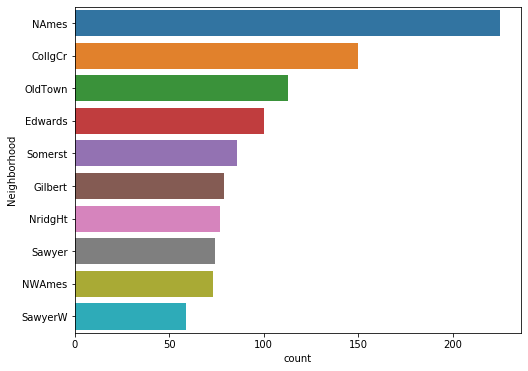

In [133]:
def describe_cat_col(df, col_name, top_N = 10, plot_size = (8,6)):
    
    '''
    Describe basic stats of a categorical column in a DataFrame
    df: DataFrame
    col_name: column name
    top_N: keep top N classes in count table, plot only top N classes
    plot_size: size of plot
    '''
    print('-------------------------------------')
    print('Type: ' + str(df[col_name].dtype))
    print('Rows: ' + str(df.shape[0]))
    print('Distinct: ' + str(df[col_name].nunique()))
    print('Missing: ' + str(df[col_name].isnull().sum()))
    print('Missing%: ' + str(df[col_name].isnull().sum()/df.shape[0]))
    print('-------------------------------------')
    print('Top ' + str(top_N) + ' values:') # 
    count_table_info = pd.concat([
            df[col_name].value_counts(dropna=False)[:top_N], 
            df[col_name].value_counts(dropna=False, normalize=True)[:top_N],
            df[col_name].value_counts(dropna=False, normalize=True)[:top_N].cumsum()],
            axis = 1)

    count_table_info.columns = ['Count','%','Cum.%'] 
    count_table_info = count_table_info.sort_values(by='Count', ascending=False)
    count_table_info.reset_index(inplace=True)
    count_table_info.columns = [col_name, 'Count','%','Cum.%'] 
    #count_table_info.drop('index', axis = 1, inplace = True)
    print(count_table_info)
    print('-------------------------------------')
    fig, ax = plt.subplots(figsize = plot_size)
    sns.countplot(y = col_name, data = df, order = df[col_name].value_counts().iloc[:top_N].index)

# test
describe_cat_col(df, 'Neighborhood')

In [98]:
len(df['Pclass'].value_counts())

3

-------------------------------------
Type: int64
Rows: 1460
Min: 34900
Max: 755000
Mean: 180921.19589041095
Median: 163000.0
Mode: 140000
StdDev: 79442.50288288662
Distinct: 663
Sum: 264144946
Missing: 0
Missing%: 0.0
Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529
25%: 129975.0
75%: 214000.0
IQR: 84025.0
Down: 3937.5
Up: 340037.5
-------------------------------------


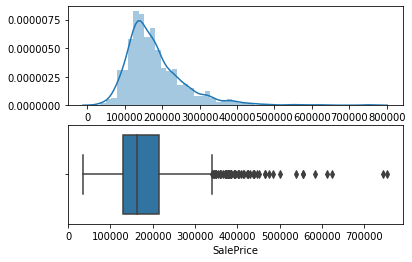

In [135]:
def describe_num_col(df, col_name):
    
    '''
    Describe basic stats of a categorical column in a DataFrame
    df: DataFrame
    col_name: column name
    '''
    print('-------------------------------------')
    print('Type: ' + str(df[col_name].dtype))
    print('Rows: ' + str(df.shape[0]))
    print('Min: ' + str(df[col_name].min()))
    print('Max: ' + str(df[col_name].max()))
    print('Mean: ' + str(df[col_name].mean()))
    print('Median: ' + str(df[col_name].median()))
    print('Mode: '+ str(df[col_name].value_counts().index[0]))
    print('StdDev: ' + str(df[col_name].std()))
    print('Distinct: ' + str(df[col_name].nunique()))
    print('Sum: ' + str(df[col_name].sum()))
    print('Missing: ' + str(df[col_name].isnull().sum()))
    print('Missing%: ' + str(df[col_name].isnull().sum()/df.shape[0]))
    print('Skewness: ' + str(df[col_name].skew()))
    print('Kurtosis: ' + str(df[col_name].kurtosis()))
        
    Q1 = df[col_name].quantile(q = 0.25)
    Q3 = df[col_name].quantile(q = 0.75)
    IQR = Q3 - Q1
    upBound = 1.5 * IQR + Q3
    downBound = Q1 - 1.5 * IQR
    
    print('25%: ' + str(Q1))
    print('75%: ' + str(Q3))
    print('IQR: ' + str(IQR))
    print('Down: ' + str(downBound))
    print('Up: ' + str(upBound))
    print('-------------------------------------')
    fig, ax = plt.subplots(2,1)
    sns.distplot(df[col_name], ax=ax[0])
    sns.boxplot(df[col_name], ax=ax[1])

# test
describe_num_col(df, 'SalePrice')

In [5]:
def split_data(df, target, test_size):
    '''
    test_size: in decimal
    '''
    X = df.drop(target, axis = 1, inplace = False)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=1)
    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    return X_train, X_test, y_train, y_test

# test
X_train, X_test, y_train, y_test = split_data(df, 'Survived', 0.2)

(712, 11) (179, 11) (712,) (179,)


In [8]:
y_train.value_counts()

0    443
1    269
Name: Survived, dtype: int64

In [5]:
def split_data2(df, target, test_size, save = False):
    '''
    test_size: in decimal
    '''
    X = df.drop(target, axis = 1, inplace = False)
    y = df[target]
    cols = X.columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=1)
    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    
    if save is True:
        train.to_csv('train.csv', index = False)
        test.to_csv('test.csv', index = False)
    
    return train,test

# test
train, test = split_data2(df, 'Survived', 0.2, True)

NameError: name 'df' is not defined

In [9]:
df=pd.read_csv('titanic.csv')
train,test = split_data2(df, 'Survived', 0.05, save = False)
train.to_csv('data.csv', index = False)
test.drop('Survived',axis = 1).to_csv('to_predict.csv', index = False)

(846, 11) (45, 11) (846,) (45,)


In [9]:
def impute(df1, df2 = None, col_dict):
    '''
    df1: to fit_transform
    df2: to transform
    col_dict: a dictionary (key: col name, value: impute method)
    '''
    for col in col_dict:
        if col_dict[col] == 'mean':
            temp = df1[col].mean()
        elif col_dict[col] == 'median':
            temp = df1[col].median()
        elif col_dict[col] == 'mode':
            temp = df1[col].value_counts().index[0]
        else:
            temp = col_dict[col]
        #print(temp)   
            
        df1[col].fillna(temp, inplace = True)
        if df2 is not None:
            df2[col].fillna(temp, inplace = True)
    
#test
impute(X_train, X_test, {'Sex': 'mode', 'Embarked': 'mode', 'Pclass': 'mode',\
                       'Age': 'median', 'SibSp': 'median', 'Parch': 'median', 'Fare': 'median', 
                      })
X_train.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [10]:
def clear_outliers_by_IQR(df, col_list): # do this without missing values in df[col]
    for col in col_list:
        if df[col].isna().sum()!=0:
            print('Impute missing values for ' + col + ' first!')
            continue
        q1 = np.percentile(df[col].tolist(), 25)
        q3 = np.percentile(df[col].tolist(), 75)
        #print(q1, q3)
        iqr = q3 - q1
        upbound = q3 + 1.5 * iqr
        downbound = q1 - 1.5 * iqr
        #print(upbound, downbound)
        col_type = df[col].dtype
        df.loc[ (df[col]<downbound) | (df[col]>upbound), col] = 'NaN'
        df[col] = df[col].astype(col_type)
        
#test
# clear_outliers_by_IQR(X_train, ['Age'])
# X_train['Age'].isna().sum()
# describe_col(X_train, 'Age', None)

In [11]:
def correlation(df, col_list = None, method = 'pearson', size=(7,6), threshold = -1):
    '''
    df: DataFrame
    col_list: list of columns to calculate correlations
    method: 'pearson', 'spearman', 'kendall'
    size: plot size
    threshold: return pairs with abs(corr)>threshold if 
    '''
    fig, ax = plt.subplots(figsize=size)
    if col_list is None:
        corr_cols = df.columns.tolist()
        corr = df.corr(method)
    else:
        corr_cols = col_list
        corr = df[col_list].corr(method)
    sns.heatmap(corr, annot=True, linewidths=.5, cmap = sns.cm.vlag)
    plt.show()
        
    if threshold > 0 and threshold < 1:
        for i in range(len(corr_cols)):
            for j in range(len(corr_cols)):
                corr_ij = corr.loc[corr_cols[i], corr_cols[j]]
                if j < i and corr_ij >= threshold:
                    print(corr_cols[i],corr_cols[j],corr_ij)

                    
# test
correlation(df = df, col_list = ['Age','Parch','Fare'], 
            method ='pearson', size = (15,15), threshold = 0.8)

In [12]:
def merge_rare(df, col_list, percentage):
    '''
    percentage: decimal, 0.00-1.00
    '''
    for col in col_list :
        df[col].mask(df[col].map(df[col].value_counts(normalize=True)) < percentage, \
                      'Other', inplace=True)
        
# test 
merge_rare(X_train,['Embarked', 'Pclass'], 0.5) 
X_train['Pclass'].value_counts()

3        388
Other    324
Name: Pclass, dtype: int64

In [45]:
def keep_top_N(df1, df2, col, N):
    '''
    N: N most frequent classes to keep in a categorical feature
    '''
    top_n = df1[col].value_counts().index.tolist()[:N]
    def f(x):
        if x not in top_n:
            return np.nan
        else:
            return x
    df1[col] = df1[col].apply(lambda x: f(x))
    if df2 is not None:
        df2[col] = df2[col].apply(lambda x: f(x))
        
    print(df1.SibSp.value_counts(dropna=False))
    if df2 is not None:
        print(df2.SibSp.value_counts(dropna=False))
    
keep_top_N(train, None, 'SibSp', 3)  

0.0    483
1.0    176
NaN     32
2.0     21
Name: SibSp, dtype: int64


In [35]:
top_n = df.SibSp.value_counts().index.tolist()[:3]
print(top_n)

def f(x):
    if x not in top_n:
        return np.nan
    else:
        return x
    
df['SibSp'] = df['SibSp'].apply(lambda x: f(x))

df.SibSp.value_counts(dropna = False)

[0, 1, 2]


0.0    608
1.0    209
NaN     46
2.0     28
Name: SibSp, dtype: int64

In [22]:
df.SibSp.value_counts()

Series([], Name: SibSp, dtype: int64)

In [13]:
def encode(df1, df2, num_col, cat_col):

    dv = DictVectorizer(sparse=False)
    cls_cat1 = dv.fit_transform(df1[cat_col].to_dict(orient='record'))
    df1_cat = pd.DataFrame(data = cls_cat1, columns = dv.feature_names_)
    
    ss = StandardScaler()
    cls_num1 = ss.fit_transform(df1[num_col])
    df1_num = pd.DataFrame(cls_num1,columns = num_col)
    
    df1_encoded = pd.concat([df1_num,df1_cat],axis=1)
   
    if df2 is not None:
        cls_cat2 = dv.transform(df2[cat_col].to_dict(orient='record'))
        df2_cat = pd.DataFrame(data = cls_cat2, columns = dv.feature_names_)
        cls_num2 = ss.transform(df2[num_col])
        df2_num = pd.DataFrame(cls_num2,columns = num_col)
        df2_encoded = pd.concat([df2_num,df2_cat],axis=1)

    return df1_encoded, df2_encoded
    
    
#test
X_train_encoded, X_test_encoded = encode(X_train, X_test, num_col, cat_col)
# Pclass is not transformed cuz it is already numerial

In [14]:
X_train_encoded.head()

,Age,SibSp,Parch,Fare,Embarked=Other,Embarked=S,Pclass,Pclass=Other,Sex=female,Sex=male
0,-0.070132,1.491053,-0.478173,-0.188014,1.0,0.0,3.0,0.0,0.0,1.0
1,0.005249,-0.489600,-0.478173,0.539690,1.0,0.0,0.0,1.0,1.0,0.0
2,0.306775,-0.489600,-0.478173,-0.463503,0.0,1.0,0.0,1.0,1.0,0.0
3,-0.673183,1.491053,-0.478173,0.897735,0.0,1.0,0.0,1.0,0.0,1.0
4,2.417453,-0.489600,-0.478173,-0.463503,0.0,1.0,0.0,1.0,0.0,1.0


In [ ]:
## under sampling
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

rus = RUS(random_state=1) 
X_train_res,y_train_res=rus.fit_resample(X_train,y_train)

# over sampling
adasyn = ADASYN()
X_res,y_res=adasyn.fit_resample(X,y)

In [ ]:
def resampling(X, y, method):
    '''
    method: 'random_under'
            'adasyn_over'
            'smote_over'
    '''
    
    if method == 'random_under':
        sampler = RandomUnderSampler()
    if method == 'adasyn_over':
        sampler = ADASYN()
    if method = 'smote_over':
        sampler = SMOTE()
    
    X_res,y_res = sampler.fit_transform(X,y)
    return X_res, y_res


In [ ]:
# hold-out validation
model=RF(class_weight = 'balanced')
model.fit(X_train,y_train)
y_pred = model.predict(X_val)
print("Confusion_Matrix:")
print(str(confusion_matrix(y_test,y_pred)))
print(classification_report(y_test,y_pred))
print("Accuracy:" + str(accuracy_score(y_test, y_pred)))
print("AUC_ROC:" + str(roc_auc_score(y_test, y_pred)))
importance_list = sorted(zip(model.feature_importances_, X_train_origin.columns.to_list()), reverse=True)
print("Feature importance: ")
pprint(importance_list[:10])

In [ ]:
# cross-validation
model = RF(class_weight='balanced')

# score: roc_auc(bin), accuracy, roc_auc_ovo_weighted
# choose the best model here
acc = cross_val_score(model,X_train,y_train,cv=3,scoring='accuracy').mean()
print("Accuracy : " + str(acc))

y_pred = cross_val_predict(model, X_train, y_train, cv=3)
conf_mat = confusion_matrix(y_train, y_pred)
print("Confusion matrix:")
print(conf_mat)
print()
print(classification_report(y_train, y_pred))